# Homework 3: VQ-VAE and WGAN

## Task 1: Theory (6pt)

### Problem 1: ELBO surgery (2pt)

At the lecture we proved the [ELBO surgery](https://www.cs.columbia.edu/~blei/fogm/2020F/readings/HoffmanJohnson2016.pdf) theorem:
$$
    \frac{1}{n} \sum_{i=1}^n KL(q(\mathbf{z} | \mathbf{x}_i) || p(\mathbf{z})) = KL(q_{\text{agg}}(\mathbf{z}) || p(\mathbf{z})) + \mathbb{I}_{q} [\mathbf{x}, \mathbf{z}],
$$
where the first term is $KL(q_{\text{agg}}(\mathbf{z}) || p(\mathbf{z}))$ includes the aggregated posterior distribution $q_{\text{agg}}(\mathbf{z})$ and the prior distribution $p(\mathbf{z})$. Our goal now is to deal with the second term. At the lecture, the second term was equal to:

$$
    \mathbb{I}_{q} [\mathbf{x}, \mathbf{z}] = \frac{1}{n}\sum_{i=1}^n KL(q(\mathbf{z} | \mathbf{x}_i) || q_{\text{agg}}(\mathbf{z})).
$$
In fact, this is a mutual information between $\mathbf{x}$ and $\mathbf{z}$ on the empirical distribution of data and the distribution of $q(\mathbf{z} | \mathbf{x})$. Let treat the index of the sample $i$ as a random variable.
$$
    q(i, \mathbf{z}) = q(i) q(\mathbf{z} | i); \quad p(i, \mathbf{z}) = p(i) p(\mathbf{z}); \quad
    q(i) = p(i) = \frac{1}{n}.
$$
$$
    \quad q(\mathbf{z} | i) = q(\mathbf{z} | \mathbf{x}_i) \quad q_{\text{agg}}(\mathbf{z}) = \sum_{i=1}^n q(i, \mathbf{z}) = \frac{1}{n} \sum_{i=1}^n q(\mathbf{z} | \mathbf{x}_i);  
$$
Mutual information is a measure of independence between two random variables.
$$
	\mathbb{I}_{q} [\mathbf{x}, \mathbf{z}] = \mathbb{E}_{q(i, \mathbf{z})} \log \frac{q(i, \mathbf{z})}{q(i)q_{\text{agg}}(\mathbf{z})}.
$$
Prove that 2 expressions for the mutual information are equal to each other.

```
your solution
```

### Problem 2: Conjugate functions / f-GAN (2pt)

We have discussed f-divergence minimization at homework 1. 
There is [paper](https://arxiv.org/pdf/1606.00709) that shows how to approximate any f-divergence using adversarial loss. 
We highly advice to read it, the math is cool. 
Here we will use this framework without proof:
$$
    D_f(\pi || p) \geq \sup_{T \in \mathcal{T}} \left[\mathbb{E}_{\pi}T(\mathbf{x}) -  \mathbb{E}_p f^*(T(\mathbf{x})) \right].
$$
The idea is the following: there is a lower bound on f-divergence which are given by variational inequality. So we could minimize this bound instead of initial f-divergence.

Here
$$
	f^*(t) = \sup_{u \in \text{dom}_f} \left( ut - f(u) \right)
$$
is a Fenchel conjugate function.

In this task you have to derive standard GAN objective from the variational inequality.

Let define function $f(u) = u \log u - (u + 1) \log (u + 1)$.

- Find $\text{dom}(f)$.
- Show that $f^*(t) = - \log (1 - e^t)$.
- Use reparametrization $T(\mathbf{x}) = \log D(\mathbf{x})$ to get the standard GAN objective (note that $D(\mathbf{x}) \in (0, 1)$, explain why this reparametrization is correct).


```your solution```

### Problem 3: Frechet Inception Distance  (2pt)
Let prove the theorem from the lecture.
Remember the Wasserstein metric:
$$
    W_s(\pi, p) = \inf_{\gamma \in \Gamma(\pi, p)} \left(\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \gamma} \| \mathbf{x} - \mathbf{y} \|^s\right)^{1/s}
$$

Consider the case $\mathbf{x} \sim \pi(\mathbf{x}) = \mathcal{N}(\boldsymbol{\mu}_1, \sigma_1^2 \mathbf{I})$, $\mathbf{y} \sim p(\mathbf{y}) = \mathcal{N}(\boldsymbol{\mu}_2, \sigma_2^2 \mathbf{I})$.

Let prove that in this case
$$
    W_2^2(\pi, p) = \inf_{\gamma \in \Gamma(\pi, p)} \mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \gamma} \| \mathbf{x} - \mathbf{y} \|^2 = \| \boldsymbol{\mu}_1 - \boldsymbol{\mu}_2 \|^2 + m \cdot (\sigma_1 - \sigma_2)^2.
$$
Here $m$ is a dimensionality of the space ($\mathbf{x}, \mathbf{y} \in \mathbb{R}^m$).

**Hints:** (one of the possible solutions)
1. Consider the case $\boldsymbol{\mu}_1 = \boldsymbol{\mu}_2 = 0$.
2. Use Cauchy–Schwarz inequality to prove that the value given above is a minimal.
2. Find the analytical mapping between $\mathbf{x}$ and $\mathbf{y}$ that gives this value.

```
your solution
```

In [ ]:
COMMIT_HASH = "79dfd7865ba692235f0a4d5aed20ee2820a19007"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

In [2]:
from dgm_utils import train_model, train_adversarial
from dgm_utils import show_samples, visualize_images, load_dataset
from dgm_utils import BaseModel

In [ ]:
import os
import numpy as np

from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

## Task 2: VQ-VAE on MNIST (5 pt)

### Training of VQ-VAE model

In this part you will train [VQ-VAE](https://arxiv.org/abs/1711.00937) model that we have discussed at the lecture (see also [VQ-VAE-2](https://arxiv.org/abs/1906.00446) paper).

We will you MNIST dataset in this task.

In [ ]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=True)
train_data, test_data = train_data.astype("float32"), test_data.astype("float32")
visualize_images(train_data, "MNIST samples")

VQ-VAE model is a VAE model with discrete latent variable.  

**Reminder:**
* We define  dictionary (word book) space $\{\mathbf{e}_k\}_{k=1}^K$, where $\mathbf{e}_k \in \mathbb{R}^C$, $K$ is the size of the dictionary.
* $\mathbf{z}_e = \text{NN}_e(\mathbf{x}, \boldsymbol{\phi})$ - continuous output of encoder network.
* $\mathbf{z}_q = \mathbf{e}_{k^*}$ is a quantized representation, where $k^* = \text{argmin}_k \| \mathbf{z} - \mathbf{e}_k \|$. It is simple nearest neighbor look up.
* Out deterministic variational posterior:
$$
  q(c = k^* | \mathbf{x}, \boldsymbol{\phi}) = \begin{cases}
  1 , \quad \text{for } k^* = \text{argmin}_k \| \mathbf{z}_e - \mathbf{e}_k \|; \\
  0, \quad \text{otherwise}.
\end{cases}
$$
* Prior distribution is uniform: $p(c) = \text{Uniform}\{1, \dots, K\}$.
* KL divergence between posterior and prior:
$$
  KL(q(c = k^* | \mathbf{x}, \boldsymbol{\phi}), p(c)) = \log K.
$$
* ELBO:
$$
		\mathcal{L} (\boldsymbol{\phi}, \boldsymbol{\theta})  = \mathbb{E}_{q(c | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{e}_{c} , \boldsymbol{\theta}) - \log K =  \log p(\mathbf{x} | \mathbf{z}_q, \boldsymbol{\theta}) - \log K.
$$
* Vector quantization is non-differentiable operation. We will use **straight-through** gradient estimator (we will copy gradients from decoder input $\mathbf{z}_q$ to encoder output $\mathbf{z}_e$.

**Important modifications:**
Due to the straight-through gradient estimation of mapping from $\mathbf{z}_e$ to $\mathbf{z}_q$, the embeddings $\mathbf{e}$ receive no gradients from the ELBO.

Therefore, in order to learn the embedding space we add l2 loss (**codebook loss**) to move the embedding vectors $\mathbf{e}$ towards the encoder outputs $\mathbf{z}_e$.

Finally, since the volume of the embedding space is dimensionless, it can grow arbitrarily if the embeddings $\mathbf{e}$ do not train as fast as the encoder parameters. To make sure the encoder commits to an embedding and its output does not grow, we add a **commitment loss**.

Thus, the total training objective becomes:
$$
  \log p(\mathbf{x}| \mathbf{z}_q, \boldsymbol{\theta}) + \| \text{stop\_gradient}(\mathbf{z}_e) - \mathbf{e}\|_2^2 + \| \mathbf{z}_e - \text{stop\_gradient}(\mathbf{e})\|_2^2.
$$

Pay attention to the $\text{stop\_gradient}(*)$ operator.


Our first step is implement vector quantization procedure. It will also calculate two consistency losses.

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(
        self, num_embeddings: int = 128, embedding_dim: int = 16, beta: float = 0.25
    ) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.beta = beta

        # Initialize the embeddings which we will quantize.
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def get_code_indices(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1).contiguous()
        input_shape = x.shape[:-1]
        flattened = x.view(-1, self.embedding_dim)
        # ====
        # your code
        # 1) calculate distances from flatten inputs to embeddings
        # 2) find nearest embeddings to each input (use argmin op)

        # ====
        encoding_indices = encoding_indices.view(input_shape)
        return encoding_indices

    def get_quantized(self, encoding_indices: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) get embeddgins with appropriate indices
        # 2) transform tensor from BHWC to BCHW format

        # ====
        return quantized

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # 1) get indices
        # 2) get quantized latents
        # 3) calculate codebook and commitment loss
        #    do not afraid about stop_gradient op
        #    (use .detach() method for quantized latents and x)
        # 4) final loss is codebook_loss + beta * commitment_loss

        # ====

        # Straight-through estimator (think about it!).
        quantized = x + (quantized - x).detach()

        return quantized, loss


def test_vector_quantizer():
    x = torch.zeros((1, 16, 7, 7))
    layer = VectorQuantizer()
    indices = layer.get_code_indices(x)
    assert indices.shape == (1, 7, 7)
    quantized = layer.get_quantized(indices)
    assert quantized.shape == (1, 16, 7, 7)
    quantized, loss = layer(x)
    assert quantized.shape == (1, 16, 7, 7)
    assert loss.shape == ()


test_vector_quantizer()

We will use simple encoder/decoder with several strided convolutions.

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        # ====
        # your code
        # define Sequential model with Conv2d and ReLU activation

        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ConvDecoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        # ====
        # your code
        # define Sequential model with ConvTransposed2d and ReLU activation

        # ====

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)

Now we are ready to define our model. It consists of encoder, decoder and vector quantizer.

In [ ]:
class VQVAEModel(BaseModel):
    def __init__(
        self,
        ce_loss_scale: float = 1.0,
        latent_dim: int = 16,
        num_embeddings: int = 64,
        latent_size: tuple = (7, 7),
    ) -> None:
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)
        self.vq_layer = VectorQuantizer(num_embeddings, latent_dim)
        self.ce_loss_scale = ce_loss_scale
        self.latent_size = latent_size

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # 1) apply encoder
        # 2) apply vector quantizer (it returns quantized representation + vq_loss)
        # 3) apply decoder (it returns decoded samples)

        # ====
        return decoded, vq_loss

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        # 1) apply model
        # 2) get cross entropy loss

        # ====
        return {
            "total_loss": self.ce_loss_scale * ce_loss + vq_loss,
            "ce_loss": self.ce_loss_scale * ce_loss,
            "vq_loss": vq_loss,
        }

    def get_indices(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) apply encoder
        # 2) get indices of codes using vector quantizer

        # ====
        return codebook_indices

    def prior(self, n: int) -> torch.Tensor:
        # ====
        # your code
        # prior distribution is uniform
        # 1) get samples from categorical distribution
        # 2) get quantized representations using vector quantizer

        # ====
        return quantized

    def sample_from_logits(self, logits: torch.Tensor) -> np.ndarray:
        # ====
        # your code
        # our model will return logits, this method applies softmax and samples from the distribution
        # 1) apply softmax to the logits
        # 2) sample from the distribution (e.x. you could use torch.multinomial)
        # be careful with the sizes of the tensors (may be you need to permute/reshape dimensios)

        # ====
        return samples.cpu().numpy()

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():
            # ====
            # your code
            # 1) sample from prior distribution
            # 2) apply decoder
            # 3) sample from logits

            # ====
            return samples.astype(float)


def test_vqvae_model():
    model = VQVAEModel().cuda()
    x = torch.zeros((2, 1, 28, 28)).cuda()

    encoded = model.encoder(x)
    size = encoded.shape[2:]
    assert size == model.latent_size

    indices = model.get_indices(x)
    assert indices.shape == (2, 7, 7)

    losses = model.loss(x)
    assert isinstance(losses, dict)
    assert "total_loss" in losses

    quantized = model.prior(10)
    assert quantized.shape == (10, 16, *model.latent_size)

    decoded = model.decoder(quantized)
    assert decoded.shape == (10, 2, 28, 28)

    sampled = model.sample(10)
    assert sampled.shape == (10, 1, 28, 28)


test_vqvae_model()

Let's train our model!

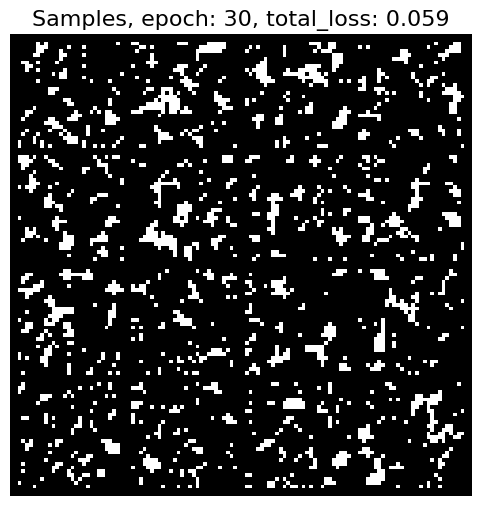

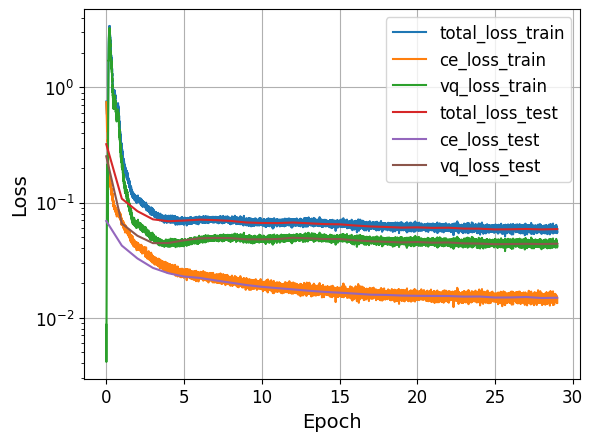

End of the training


In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 
EPOCHS = 
LR = 
CE_SCALE = 
# ====

model = VQVAEModel(ce_loss_scale=CE_SCALE, latent_dim=16, num_embeddings=128)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# ====
# your code
# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# ====

train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
    logscale_y=True,
)

Now we is able to sample from the trained model.

In [ ]:
# Samples
samples = model.sample(100)
show_samples(samples, title="Samples")

# Reconstructions
output = next(iter(test_loader))[:50].cuda()
with torch.no_grad():
    decoded, _ = model(output)
    x_recon = model.sample_from_logits(decoded)
output = output.cpu().numpy()
reconstructions = np.concatenate((output, x_recon), axis=0)
reconstructions = reconstructions.astype("float32")
show_samples(reconstructions, title="Reconstructions")

Probably you will get bad samples :(

Do not worry, may be it is ok, we will try to fix your samples! Make sure that reconstructions are almost perfect.

Here, we will visualize latent code indices for test images.

In [ ]:
test_images = next(iter(test_loader))[:100]
output = test_images.cuda()
codebook_indices = model.get_indices(output).cpu().unsqueeze(1)

show_samples(test_images, "Test images")
show_samples(codebook_indices, "Test codes")

### Training of prior autoregressive model

The samples from our VQ-VAE model is not good enough. The authors of the original VQ-VAE paper proposed to train autoregressive model in the latent space after we trained VQ-VAE model.

Remember we have discussed **ELBO surgery** and **aggregrated posterior**. Let recall what do we have in VAE:
* **Training:** we get latent variables $\mathbf{z}$ from variational posterior $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})$ for every object $\mathbf{x}$ and then applies decoder ($p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$). It means that in average decoder is applied to the latent variables from aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$.
* **Inference:** We apply decoder to the latent variables from prior distribution $p(\mathbf{z})$.

It means that if our aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$ and prior $p(\mathbf{z})$ is too far from each other, then we get inconsistency.

So let train to remove this inconsistency. To be concrete, let train (autoregressive) model in the latent space that will try to predict samples from the aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$.

We will use our good friend: PixelCNN model.

In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(
        self, mask_type: str, in_channels: int, out_channels: int, kernel_size: int = 5
    ) -> None:
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code

        # ====

    def create_mask(self, mask_type: str) -> None:
        # ====
        # your code
        # do not forget about mask_type

        # ====


def test_masked_conv2d():
    layer = MaskedConv2d("A", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d("B", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

In [ ]:
class PixelCNN(BaseModel):
    def __init__(
        self,
        num_embeddings: int = 128,
        input_shape: tuple = (8, 8),
        n_filters: int = 32,
        kernel_size: int = 5,
        n_layers: int = 5,
    ) -> None:

        super().__init__()
        self.input_shape = input_shape
        self.num_embeddings = num_embeddings

        # ====
        # your code
        # apply the sequence of MaskedConv2d -> ReLU
        # the last layer should be MaskedConv2d (not ReLU)
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be 2

        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # read the forward method carefully
        flattened = x.view((-1, 1))
        encodings = torch.zeros(flattened.shape[0], self.num_embeddings).cuda()
        encodings.scatter_(1, flattened, 1)
        encodings = encodings.view((-1, *self.input_shape, self.num_embeddings))
        encodings = encodings.permute((0, 3, 1, 2))
        out = self.net(encodings)
        out = out.view(-1, self.num_embeddings, 1, *self.input_shape)
        return out

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        
        # ====
        return {"total_loss": total_loss}

    def sample(self, n: int) -> np.ndarray:
        # read carefully the sampling process
        samples = torch.zeros(n, 1, *self.input_shape, dtype=torch.int64).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1).squeeze(-1)
                    samples[:, 0, r, c] = torch.multinomial(
                        probs, num_samples=1
                    ).squeeze(-1)
        return samples.cpu().numpy()


def test_pixelcnn():
    model = PixelCNN().cuda()
    x = torch.zeros((1, 1, 8, 8), dtype=torch.int64).cuda()
    output = model(x)
    assert output.shape == (1, 128, 1, 8, 8)
    losses = model.loss(x)
    assert isinstance(losses, dict)
    assert "total_loss" in losses
    samples = model.sample(10)
    assert samples.shape == (10, 1, 8, 8)


test_pixelcnn()

Now we need to get our train and test samples. Our model will predict indices of the embeddings.

In [ ]:
# ====
# your code
# you have to get indices of the emdeddings from the VQ-VAE model for train and test data

# ====

assert isinstance(train_indices, np.ndarray)
assert isinstance(test_indices, np.ndarray)
assert train_indices.shape == (60000, 1, *INPUT_SHAPE)
assert test_indices.shape == (10000, 1, *INPUT_SHAPE)

Epoch: 20, loss: 0.9126454670546151


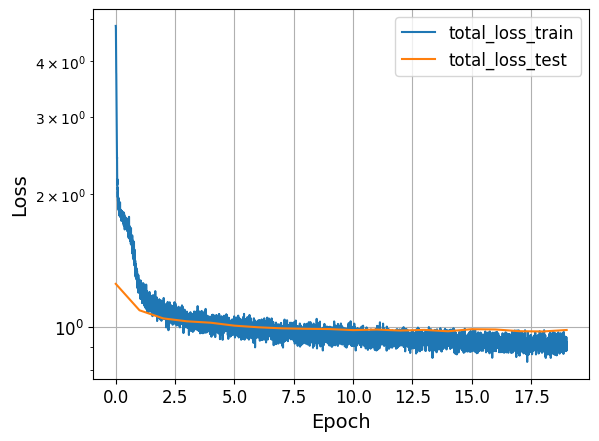

End of the training


In [ ]:
# ====
# your code
# choose these parameters by your own
EPOCHS = 
BATCH_SIZE = 
LR = 
N_LAYERS = 
N_FILTERS = 
# ====

prior_model = PixelCNN(
    input_shape=INPUT_SHAPE, n_filters=N_FILTERS, kernel_size=5, n_layers=N_LAYERS
)

train_loader = data.DataLoader(train_indices, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_indices, batch_size=BATCH_SIZE)

# ====
# your code
# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(prior_model.parameters(), lr=LR)
# ====

train_model(
    prior_model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    visualize_samples=False,
    logscale_y=True,
)

Now we are ready to sample from our VQ-VAE model. The difference here that we will sample our embedding indices from the PixelCNN prior model instead of the Uniform prior distribution.

In [ ]:
N_SAMPLES = 100
indices = prior_model.sample(N_SAMPLES).squeeze(1)
quantized = model.vq_layer.get_quantized(torch.Tensor(indices).int().cuda())
logits = model.decoder(quantized)
samples = model.sample_from_logits(logits)

samples = samples.astype("float32")
show_samples(samples, title="Samples")

## Task 3: Wasserstein GANs for CIFAR 10 (4pt)

In this task you will fit different kinds of Wasserstein GANs (different ways to enforce Lipschitzness) that we discussed at the lecture to the CIFAR10 dataset
* [WGAN](https://arxiv.org/abs/1701.07875) - standard Wasserstein GAN with weight clipping;
* [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf) - Wasserstein GAN with Gradient Penalty.

In [ ]:
train_data, test_data = load_dataset("cifar10", flatten=False, binarize=False)
visualize_images(train_data, "CIFAR10 samples")

### Problem 1: WGAN (3pt)

[WGAN](https://arxiv.org/abs/1701.07875) model uses weight clipping to enforce Lipschitzness of the critic.

The model objective is
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f_{\boldsymbol{\phi}}(\mathbf{x})  - \mathbb{E}_{p(\mathbf{z})} f_{\boldsymbol{\phi}}(G_{\boldsymbol{\theta}}(\mathbf{z}))\right].
$$
Here $f_{\boldsymbol{\phi}}(\mathbf{x})$ is the critic model. The critic weights $\boldsymbol{\phi}$ should lie in the compact set $\boldsymbol{\Phi} = [-c, c]^d$.

In this task we will use convolutional networks for the generator $G_{\boldsymbol{\theta}}(\mathbf{z})$ and the critic $f_{\boldsymbol{\phi}}(\mathbf{x})$.

First of all, let define generator network. It will be the same for all WGAN models.

In [ ]:
class GeneratorBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, upsample: bool = False) -> None:
        super().__init__()

        self.upsample = upsample
        if in_channels != out_channels:
            self.shortcut_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut_conv = None

        # ====
        # your code
        # define the layers

        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # ====
        # your code
        # 1) create shortcut: if upsample is True, apply upsampling
        # 2) if shortcut_conv is not None, apply it
        # 3) apply main conv layers to x
        # NOTE: do not forget to add shortcut to x at the end
        
        # ====

In [ ]:
class ConvGenerator(nn.Module):
    def __init__(self, input_size: int = 128, n_channels: int = 64) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.input_size = input_size
        # ====
        # your code
        # define the model as a sequence of layers
        # 1) start with Linear layer
        # 2) then define generator blocks
        # 3) create last conv layer with tanh activation

        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # apply all layers

        # ====
        return output
        
        
def test_conv_generator():
    model = ConvGenerator(input_size=4, n_channels=32)
    x = torch.randn((2, 4))
    out = model(x)
    assert list(out.size()) == [2, 3, 32, 32], out.size()
    
test_conv_generator()

Now it is time to define our critic. Here we will use the same class for all WGAN models, but the arguments will depend on the WGAN mode.

In [ ]:
def avg_pool2d(x: torch.Tensor) -> torch.Tensor:
    return (x[:, :, ::2, ::2] + x[:, :, 1::2, ::2] + x[:, :, ::2, 1::2] + x[:, :, 1::2, 1::2]) / 4

class CriticBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, downsample=False, first=False):
        super().__init__()

        self.downsample = downsample
        self.first = first

        if in_channels != out_channels:
            self.shortcut_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut_conv = None
        # ====
        # your code
        # define the layers if block is first do not define ReLU
        # NOTE: do not use BatchNorm, because the gradient penalty (next task) 
        # should be independently imposed on different samples, 
        # but batch normalization brings batch correlation.

        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) create shortcut: if downsample is True, apply avg_pool
        # 2) if shortcut_conv is not None, apply it
        # 3) apply main conv layers to x
        # NOTE: do not forget to add shortcut to x at the end

        # ====

In [ ]:
class ConvCritic(nn.Module):
    def __init__(
        self, n_channels: int, clip_c: Optional[float] = None,
    ) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.clip_c = clip_c
        
        # ====
        # your code
        # define the model as a sequence of layers
        # 1) define generator blocks
        # 2) do not use sigmoid activation at the end!

        # ====

    def clip_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                # ====
                # your code
                # clip the weight to the range [-clip_c, clip_c]

                # ====
                module.weight.data = weight
                module.bias.data = bias

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) clip the critic weights (if clip_c is given)
        # 2) apply all layers

        # ====
        return output
        
        
def test_conv_critic():
    model = ConvCritic(n_channels=4, clip_c=0.01)
    x = torch.randn((2, 3, 32, 32))
    out = model(x)
    assert list(out.size()) == [2, 1], out.size()

    
test_conv_critic()

In [ ]:
class WGAN(BaseModel):
    def __init__(
        self,
        input_size: int = 128, 
        n_channels: int = 64, 
        clip_c: Optional[float] = None,
    ) -> None:
        super().__init__()
        self.input_size = input_size
        self.generator = ConvGenerator(input_size, n_channels)
        self.discriminator = ConvCritic(n_channels, clip_c)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.generator(x)
    
    def loss_generator(self, batch_size) -> dict:
        # ====
        # your code
        # 1) sample batch 
        # NOTE: sample function uses torch.no_grad
        # 2) apply generator loss (only term with genrator)

        # ====
        return {"generator_loss": g_loss}

    def loss_discriminator(self, x: torch.Tensor) -> dict:
        fake_data = self.sample(x.shape[0])
        # ====
        # your code
        # calculate critic loss (both terms)

        # ====
        return {"critic_loss": d_loss, "critic_loss_fake": d_loss_fake, "critic_loss_real": d_loss_real}
    
    @torch.no_grad()
    def sample(self, n_samples: int) -> torch.Tensor:
        # ====
        # your code
        # sample from standard normal distribution and apply the model

        # ====
        return output
    
def test_wgan():
    model = WGAN(input_size=4, n_channels=32)
    x = torch.randn((2, 4))
    out = model(x)
    assert list(out.size()) == [2, 3, 32, 32], out.size()
    
    out = model.sample(10)
    assert list(out.size()) == [10, 3, 32, 32], out.size()

    loss = model.loss_generator(10)
    assert isinstance(loss, dict)
    
    x = torch.randn((2, 3, 32, 32))
    loss = model.loss_discriminator(x)
    assert isinstance(loss, dict)
    
test_wgan()
        

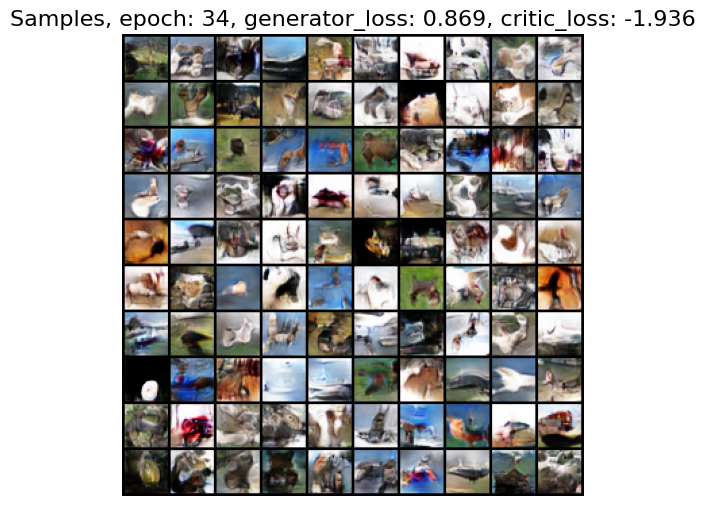

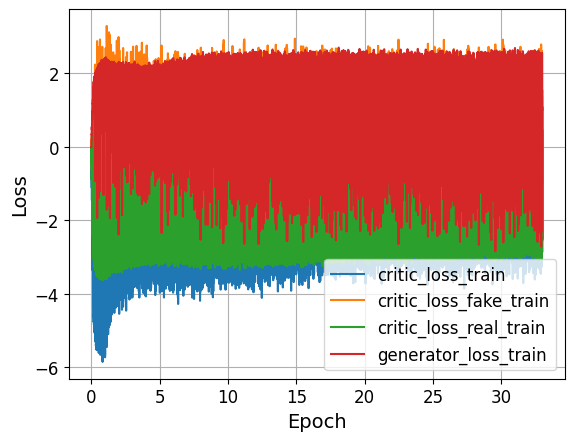

Training epoch 35:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 
N_CHANNELS = 
EPOCHS = 
CRITIC_STEPS = 
CLIP_C = 
LR = 
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
wgan = WGAN(input_size=128, n_channels=N_CHANNELS, clip_c=CLIP_C)

# choose any optimizer as you want
generator_optimizer = torch.optim.Adam(wgan.generator.parameters(), lr=LR, betas=(0.0, 0.9))
discriminator_optimizer = torch.optim.Adam(wgan.discriminator.parameters(), lr=LR, betas=(0.0, 0.9))

train_adversarial(
    wgan,
    train_loader,
    epochs=EPOCHS,
    d_steps=CRITIC_STEPS,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    device=DEVICE,
    generator_loss_key="generator_loss",
    discriminator_loss_key="critic_loss",
    n_samples=100,
    visualize_samples=True
)

Let sample from our model and draw the samples.

In [ ]:
wgan.eval()
samples = wgan.sample(100).cpu().detach().numpy()

show_samples(samples, title="CIFAR-10 WGAN-generated samples")

### Problem 2: WGAN-GP for CIFAR 10 (2pt)

Another way to enforce Lipschitzness comes from the following [theorem](https://arxiv.org/pdf/1704.00028.pdf):

Let $\pi(\mathbf{x})$ and $p(\mathbf{x})$ be two distribution in $\mathcal{X}$, a compact metric space. Let $\gamma$ be the optimal transportation plan between $\pi(\mathbf{x})$ and $p(\mathbf{x})$. Then, there is 1-Lipschitz function $f^*$ which is the optimal solution of 
$$
    \max_{\| f \|_L \leq 1} \left[ \mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x})} f(\mathbf{x})\right].
$$

if $f^*$ is differentiable, $\gamma(\mathbf{y} = \mathbf{z}) = 0$ and $\hat{\mathbf{x}}_t = t \mathbf{y} + (1 - t) \mathbf{z}$ with $\mathbf{y} \sim \pi(\mathbf{x})$, $\mathbf{z} \sim p(\mathbf{x} | \mathbf{\theta})$, $t \in [0, 1]$ it holds that
$$
    \mathbb{P}_{(\mathbf{y}, \mathbf{z}) \sim \gamma} \left[ \nabla f^*(\hat{\mathbf{x}}_t) = \frac{\mathbf{z} - \hat{\mathbf{x}}_t}{\| \mathbf{z} - \hat{\mathbf{x}}_t \|} \right] = 1.
$$

This follows that $f^*$ has gradient norm 1 almost everywhere under $\pi(\mathbf{x})$ and $p(\mathbf{x})$. Thus, we can add a term that will enforce the gradient to equal 1:
$$
 W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}} f(\hat{\mathbf{x}}) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where $t \sim U[0,1]$ is uniformly distributed.

Let define our gradient penalty loss.

In [ ]:
class WGAN_GP(WGAN):
    def __init__(
        self,
        gp_weight: float,
        input_size: int = 128, 
        n_channels: int = 64, 
    ) -> None:
        super().__init__()
        self.input_size = input_size
        self.gp_weight = gp_weight
        self.generator = ConvGenerator(input_size, n_channels)
        self.discriminator = ConvCritic(n_channels, None)

    def gradient_penalty(
        self, real_data: torch.Tensor, fake_data: torch.Tensor
    ) -> torch.Tensor:
        batch_size = real_data.shape[0]

        # ====
        # your code
        # Calculate interpolation x_t = t * x_real + (1 - t) x_fake
        # 1) sample t
        # 2) create x_t (be careful about shapes)
        # 3) apply critic to x_t

        # ====
        gradients = torch.autograd.grad(
            outputs=d_output,
            inputs=x_t,
            grad_outputs=torch.ones(d_output.size()).to(fake_data.device),
            create_graph=True,
            retain_graph=True,
        )[0]

        gradients = gradients.reshape(batch_size, -1)
        # ====
        # your code
        # compute gradient norm

        # ====
        return ((gradients_norm - 1) ** 2).mean()
    
    def loss_discriminator(self, x: torch.Tensor) -> dict:
        fake_data = self.sample(x.shape[0])
        # ====
        # your code
        # calculate critic loss (both terms)

        # ====
        losses = {
            "critic_loss": d_loss, 
            "critic_loss_fake": d_loss_fake, 
            "critic_loss_real": d_loss_real,
            "gradient_penalty_loss": gp
        }
        return losses

That is all :)

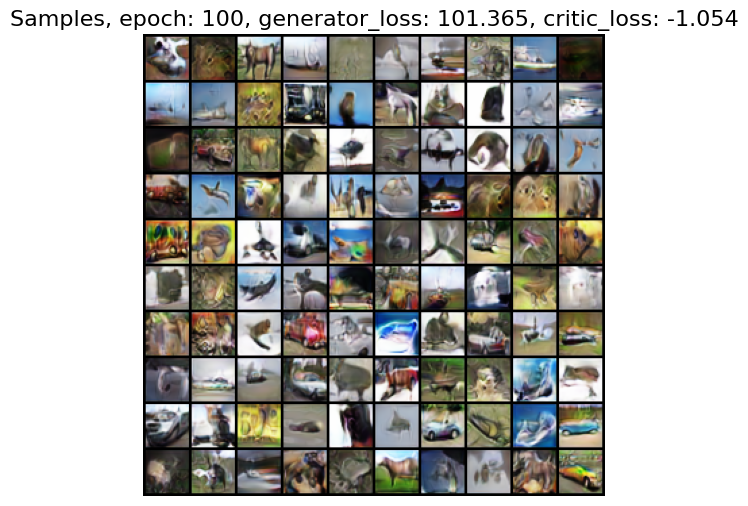

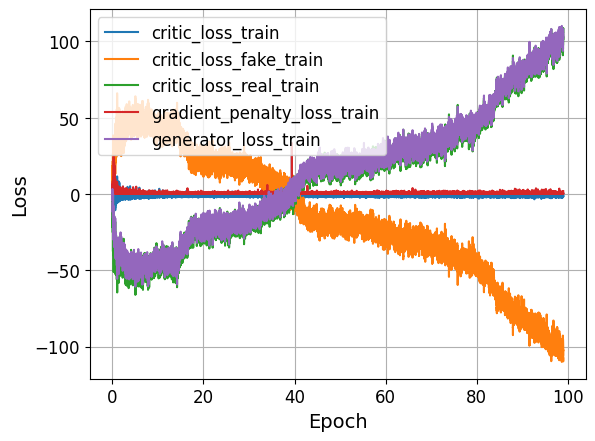

End of the training


In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 
N_CHANNELS = 
EPOCHS = 
CRITIC_STEPS = 
GP_WEIGHT = 
LR = 
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
wgan_gp = WGAN_GP(gp_weight=GP_WEIGHT, input_size=128, n_channels=N_CHANNELS)

# ====
# your code
# choose any optimizer as you want
generator_optimizer = torch.optim.Adam(wgan_gp.generator.parameters(), lr=LR, betas=(0.0, 0.9))
discriminator_optimizer = torch.optim.Adam(wgan_gp.discriminator.parameters(), lr=LR, betas=(0.0, 0.9))
# ====

train_adversarial(
    wgan_gp,
    train_loader,
    epochs=EPOCHS,
    d_steps=CRITIC_STEPS,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    device=DEVICE,
    generator_loss_key="generator_loss",
    discriminator_loss_key="critic_loss",
    n_samples=100,
    visualize_samples=True
)

Let sample from our model and draw the samples.

In [ ]:
wgan_gp.eval()
samples = wgan_gp.sample(100).cpu().detach().numpy()

show_samples(samples, title="CIFAR-10 WGAN-GP-generated samples")

Here you have to get samples with good enough quality!